# Preprocess Landsat and MODIS Data

This notebook preprocesses datasets from Landsat and MODIS, respectively. Data is from Google Earth Engine, processed, and stored as TFRecord in Google Drive, through the following steps:

1. Load city data

Only US cities are included at this moment. The data is from the 2020 US Census Bureau's [TIGER/Line Shapefiles](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html). 

2. Prepare Landsat data

Data ranges from 2003-present.

Landsat 7: collection 2 level 2 tier 1 surface reflectance data.
(Try using both two consecutive months and two same months from consecutive years.)

SLC gap fill:
Apply the USGS L7 Phase-2 Gap filling protocol, using a single kernel size. 

3. Load Modis data

Data ranges from 2003-present.

Reproject Modis to Landsat projection.

Aqua data.LST_Day_1km.

4. Download Data in TFRecord Format to Google Drive

In [1]:
######################################################## Import libraries ######################################################
import ee
import geemap
import sys
import os
import tensorflow as tf
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show as r_show
import math
import datetime
from dateutil.relativedelta import *
from gee_prep import filter_collection, rescale_rename_landsat, export_to_drive, get_gap_filled_image, preprocess_modis
from gee_prep import preprocess_modis

In [ ]:
np.set_printoptions(threshold=sys.maxsize)

In [2]:
######################################################### Define variables #####################################################
drive_folder = 'Data_TFRecord'
landsat_collection = 'LANDSAT/LE07/C02/T1_L2'
modis_collection = 'MODIS/006/MYD11A2'
us_city_collection = 'users/yiwenz9/us_cities'
city_name, city_num = ['Phoenix', 'Phoenix--Mesa, AZ']
predictors = ['Blue','Green','Red','NIR','SWIR1','SWIR2','ST']
#Preserve only the qa bands of most important images used to fill gaps.
qa_bands = ['source_mask', 'qa_pixel_0', 'qa_radsat_0','qa_pixel_1', 'qa_radsat_1', 'qa_pixel_2', 'qa_radsat_2']
target = 'LST_Day_1km'
landsat_res = 30 #m
modis_res = 1000 #m
radius = 16 #(33-1)/2 pixels

In [3]:
######################################################### Initiate a map #######################################################
Map = geemap.Map()
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value=…

In [4]:
cities = ee.FeatureCollection(us_city_collection)
target_city=cities.filter(ee.Filter.eq('NAME10',city_num))
Map.addLayer(target_city,{}, city_name)

In [13]:
start_date = datetime.date(2002, 12, 1)
end_date = datetime.date(2006, 3, 1)
delta = relativedelta(months=3)

while start_date < end_date:
    start = str(start_date)
    end = str(start_date + delta)
    print(start, end)
    landsat = filter_collection(landsat_collection, start_date=start, end_date=end,geometry=target_city)\
            .map(rescale_rename_landsat).sort('CLOUD_COVER')
    gap_filled_imgCol=get_gap_filled_image(landsat)
    img_export=gap_filled_imgCol.select(predictors+qa_bands).median().reproject(landsat.first().projection()).unmask(-9999)
    modis_reproj=preprocess_modis(modis_collection, start_date=start, end_date=end,geometry=target_city)
    modis_reproj_list = modis_reproj.toList(modis_reproj.size())
    for i in range(modis_reproj.size().getInfo()):
        modis_download = ee.Image(modis_reproj_list.get(i))
        vector=modis_download.sample(
          region= target_city.geometry(),
          dropNulls=False,
          geometries=True,
        )
        fname=ee.Date(modis_download.get('system:time_start')).format("YYMMdd").getInfo()
        print(fname)
        export_to_drive(img = img_export, region = vector, radius = radius,
                        units = 'pixels', scale = landsat_res, folder = drive_folder, fname = fname)
    start_date += delta

2002-12-01 2003-03-01
021203
021211
021219
021227
030101
030109
030117
030125
030202
030210
030218
030226
2003-03-01 2003-06-01
030306
030314
030322
030330
030407
030415
030423
030501
030509
030517
030525
2003-06-01 2003-09-01
030602
030610
030618
030626
030704
030712
030720
030728
030805
030813
030821
030829
2003-09-01 2003-12-01
030906
030914
030922
030930
031008
031016
031024
031101
031109
031117
031125
2003-12-01 2004-03-01
031203
031211
031219
031227
040101
040109
040117
040125
040202
040210
040218
040226
2004-03-01 2004-06-01
040305
040313
040321
040329
040406
040414
040422
040430
040508
040516
040524
2004-06-01 2004-09-01
040601
040609
040617
040625
040703
040711
040719
040727
040804
040812
040820
040828
2004-09-01 2004-12-01
040905
040913
040921
040929
041007
041015
041023
041031
041108
041116
041124
2004-12-01 2005-03-01
041202
041210
041218
041226
050101
050109
050117
050125
050202
050210
050218
050226
2005-03-01 2005-06-01
050306
050314
050322
050330
050407
050415
050423
050

# Read a TFRecord file

In [15]:
dataset=tf.data.TFRecordDataset(
    '050712.tfrecord.gz', compression_type='GZIP', buffer_size=None, num_parallel_reads=None
)

In [16]:
bands=['Blue','Green','Red','NIR','SWIR1','SWIR2', 'ST', 'source_mask', 'qa_pixel_0', 'qa_radsat_0','qa_pixel_1', 'qa_radsat_1']
bands=['Blue','Green','Red']
feature_names=list(bands)
feature_names

['Blue', 'Green', 'Red']

In [18]:
# List of fixed-length features, all of which are float32.
predictor_columns = [
  tf.io.FixedLenFeature(shape=[33,33], dtype=tf.float32) for k in feature_names
]
target_columns = [
  tf.io.FixedLenFeature(shape=[1], dtype=tf.float32)
]

# Dictionary with names as keys, features as values.
features_dict = dict(zip(feature_names+[target], predictor_columns+target_columns))

pprint(features_dict)

{'Blue': FixedLenFeature(shape=[33, 33], dtype=tf.float32, default_value=None),
 'Green': FixedLenFeature(shape=[33, 33], dtype=tf.float32, default_value=None),
 'LST_Day_1km': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None),
 'Red': FixedLenFeature(shape=[33, 33], dtype=tf.float32, default_value=None)}


In [47]:
#Count the number of examples in a TFRecord
dataset.reduce(np.int64(0), lambda x, _: x + 1)

<tf.Tensor: shape=(), dtype=int64, numpy=2969>

In [45]:
def input_fn(serialized_example):

 # Make a parsing function
    example = tf.io.parse_single_example(serialized_example,features_dict)
    return example
  
  # Passing of FeatureColumns to a 4D tensor
#     def stack_images(features):         
#         nfeat = tf.transpose(tf.squeeze(tf.stack(list(features.values()))))
#         return nfeat
  
#     dataset = dataset.map(parse)
#     dataset = dataset.map(stack_images)
  
#     if shuffle:
#         dataset = dataset.shuffle(buffer_size = batchSize * 10)
#     dataset = dataset.batch(batchSize)
#     dataset = dataset.repeat(numEpochs)
parsed_dataset= dataset.map(input_fn)

In [46]:
for elements in parsed_dataset.take(9):
    print(elements)

{'Blue': <tf.Tensor: shape=(33, 33), dtype=float32, numpy=
array([[ 1.08494997e-01,  1.13224998e-01,  1.37301251e-01,
         1.34963751e-01,  1.16263747e-01,  1.00657500e-01,
         1.17899999e-01,  1.27965003e-01,  1.16318747e-01,
         1.22588754e-01,  1.19453751e-01,  1.19453751e-01,
         1.06899999e-01,  1.03008747e-01,  1.19439997e-01,
         1.24926247e-01,  1.38126254e-01,  1.38112500e-01,
         1.45867497e-01,  1.41976252e-01,  1.29559994e-01,
         1.24101251e-01,  1.30343750e-01,  1.30343750e-01,
         1.24912500e-01,  1.40477493e-01,  1.66795000e-01,
         1.59823745e-01,  1.30316243e-01,  9.98462513e-02,
         8.73062536e-02,  8.96712467e-02,  1.10859998e-01],
       [ 1.16277501e-01,  1.10048749e-01,  1.30357504e-01,
         1.35720000e-01,  1.15576252e-01,  1.15576252e-01,
         1.29587501e-01,  1.44231245e-01,  1.29518747e-01,
         1.24926247e-01,  1.28803745e-01,  1.20980002e-01,
         1.09237500e-01,  1.03792503e-01,  1.16277501e-

{'Blue': <tf.Tensor: shape=(33, 33), dtype=float32, numpy=
array([[ 7.67462477e-02,  7.59899989e-02,  8.46387520e-02,
         7.83412531e-02,  7.91250020e-02,  8.54362473e-02,
         8.38687494e-02,  8.54362473e-02,  9.01525021e-02,
         8.46387520e-02,  9.33287516e-02,  1.22313753e-01,
         1.34757504e-01,  1.20705001e-01,  1.36325002e-01,
         1.40986249e-01,  1.27731249e-01,  1.49525002e-01,
         1.45606250e-01,  1.37081251e-01,  1.30096257e-01,
         1.40202507e-01,  1.52618751e-01,  1.56468749e-01,
         1.25338748e-01,  9.72337499e-02,  8.14762488e-02,
         8.70174989e-02,  9.25037488e-02,  9.08949971e-02,
         8.78012478e-02,  1.02775000e-01,  9.86912474e-02],
       [ 7.51650035e-02,  7.99087510e-02,  8.22874978e-02,
         7.99224973e-02,  7.83549994e-02,  8.54225010e-02,
         8.15037489e-02,  8.70174989e-02,  8.78150016e-02,
         8.77737477e-02,  9.17475000e-02,  1.26204997e-01,
         1.46431252e-01,  1.39391243e-01,  1.28570005e-

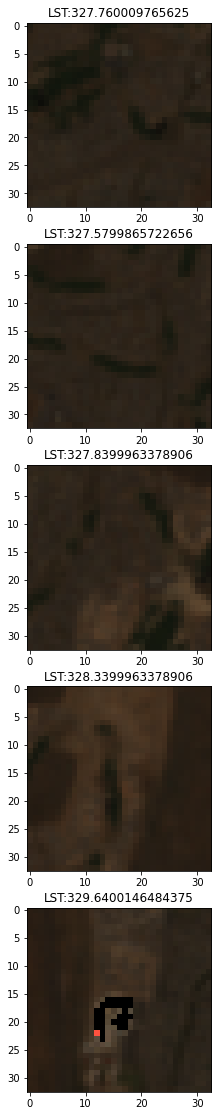

In [40]:
#rescale to 255
display_num = 10
plt.figure(figsize=(9, 40))

c=0
for i in range(5, display_num):
    for x in parsed_dataset.take(i):
        x
    Red=x['Red'].numpy().clip(0,1)
#    Red=(Red-Red.min())/(Red.max()-Red.min())
    Green=x['Green'].numpy().clip(0,1)
#    Green=(Green-Green.min())/(Green.max()-Green.min())
    Blue=x['Blue'].numpy().clip(0,1)
#    Blue=(Blue-Blue.min())/(Blue.max()-Blue.min())
    LST=x[target].numpy()[0]
#    tensor = tf.squeeze(x).numpy()
#   #print(target.sum())  
    plt.subplot(display_num, 2, c + 1)
    plt.imshow(np.stack((Red,Green,Blue),-1))
    plt.title(f'LST:{LST}')
    c+=2 
plt.savefig('TFRecord_vis')
plt.show()